# Installing dependencies

In [ ]:
pip install bert-score

**Importing required libraries**

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from bert_score import BERTScorer
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model definition

In [ ]:
class FAQDataset(Dataset):
    def __init__(self, texts, faqs, university_names, tokenizer, max_len = 256):
        self.texts = texts
        self.faqs = faqs
        self.university_names = university_names
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, id):
        source_text = self.texts[id]
        target_text = self.faqs[id]
        university_name = self.university_names[id]
        source_encodings = self.tokenizer(source_text, max_length = self.max_len, padding = 'max_length', truncation = True, return_tensors = "pt")
        target_encodings = self.tokenizer(target_text, max_length = self.max_len, padding = 'max_length', truncation = True, return_tensors = "pt")

        return {'university_name': university_name,
                'input_ids': source_encodings['input_ids'].squeeze(),
                'attention_mask': source_encodings['attention_mask'].squeeze(),
                'labels': target_encodings['input_ids'].squeeze()
               }

**Tokenizing & dataset loading**

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-large')

# Loading the dataset:
data = pd.read_csv('data.csv')
data.fillna('No data available', inplace = True) # Handing missing values.
data['FAQs'] = data['FAQs'].apply(lambda ele: " ".join(ele.split(" | "))) # Splitting X and y datapoints.
combined_data = data.groupby('University Name').agg({'Admission Text': 'first', 'FAQs': ' '.join}).reset_index()

# Split data for training and validation
train_data, temp_val_data = train_test_split(combined_data, test_size = 0.2)
val_data, test_data = train_test_split(temp_val_data, test_size = 0.5)

train_dataset = FAQDataset(train_data['Admission Text'].tolist(), train_data['FAQs'].tolist(), train_data['University Name'].tolist(), tokenizer)
val_dataset = FAQDataset(val_data['Admission Text'].tolist(), val_data['FAQs'].tolist(), val_data['University Name'].tolist(), tokenizer)
test_dataset = FAQDataset(test_data['Admission Text'].tolist(), test_data['FAQs'].tolist(), test_data['University Name'].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = False, num_workers = 4, pin_memory = True)

# Defining model parameters:
model = T5ForConditionalGeneration.from_pretrained('t5-large').to(device)
optimizer = AdamW(model.parameters(), lr = 5e-5)
epochs = 5  # Define the number of epochs for training

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training phase

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 training loss: 6.9300, validation loss: 3.7874
Epoch 2 training loss: 2.0597, validation loss: 1.2085
Epoch 3 training loss: 1.4933, validation loss: 1.1640
Epoch 4 training loss: 1.3002, validation loss: 1.3996
Epoch 5 training loss: 1.1293, validation loss: 1.1044


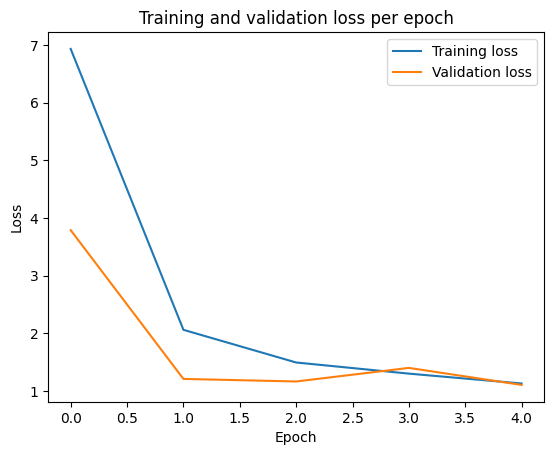

('./trained_t5_faq_generator/tokenizer_config.json',
 './trained_t5_faq_generator/special_tokens_map.json',
 './trained_t5_faq_generator/spiece.model',
 './trained_t5_faq_generator/added_tokens.json')

In [ ]:
training_losses = []
validation_losses = []

def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():  # No need to compute gradient when evaluating
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
            loss = outputs.loss
            val_loss += loss.item()

    return val_loss / len(val_loader)

model.train()

for epoch in range(epochs):
    train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = evaluate_model(model, val_loader, device)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")

plt.plot(training_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.title('Training and validation loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model
model.save_pretrained('./trained_t5_faq_generator')
tokenizer.save_pretrained('./trained_t5_faq_generator')

# Inference

In [ ]:
# Defining the FAQ generator function:
def generate_faq(model, tokenizer, text, max_length = 256):
    model.eval()
    inputs = tokenizer(text, return_tensors = "pt", max_length = max_length, truncation = True, padding = "max_length").to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        outputs = model.generate(input_ids, attention_mask = attention_mask, max_length = 256, temperature = 0.9, top_k = 50, top_p = 0.92, no_repeat_ngram_size = 2, num_return_sequences = 1)

    return tokenizer.decode(outputs[0], skip_special_tokens = True)

# Evaluation

In [ ]:
!pip install rouge

In [ ]:
# Evaluation:
results = []
model_faqs = []
scorer = BERTScorer(lang = "en", rescale_with_baseline = True)

for _, row in test_data.iterrows():
    generated_faq = generate_faq(model, tokenizer, row['Admission Text'])
    model_faqs.append(generated_faq)
    results.append({'University Name': row['University Name'],
                    'Admission Text': row['Admission Text'],
                    'Generated FAQ': generated_faq,
                    'Actual FAQ': row['FAQs'],
                   })

results_df = pd.DataFrame(results)
results_df.to_csv('Generated_faqs.csv', index = False)
reference_faqs = test_data['FAQs'].tolist()
P, R, F1 = scorer.score(model_faqs, reference_faqs, verbose = True)

print(f"BERTScore- Precision = {P.mean():.3f}, \nRecall = {R.mean():.3f}, \nF1 = {F1.mean():.3f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.28 seconds, 36.32 sentences/sec
BERTScore- Precision = -0.056, 
Recall = -0.116, 
F1 = -0.086


In [ ]:
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(model_faqs, reference_faqs, avg = True)

print("ROUGE-1:", scores['rouge-1']['f'])  # F1-score of ROUGE-1
print("ROUGE-2:", scores['rouge-2']['f'])  # F1-score of ROUGE-2
print("ROUGE-L:", scores['rouge-l']['f'])  # F1-score of ROUGE-L

ROUGE-1: 0.10318908708354294
ROUGE-2: 0.009371644453146357
ROUGE-L: 0.08980406630721782
